## Load the image of iris to Enroll

In [33]:
from ipynb.fs.full.Loading_Dataset import load_data
import cv2
import matplotlib.pyplot as plt

In [34]:
path = 'C:/Users/Mechanic/Iris Recognition/Infrared Images/'

In [35]:
data = load_data(path)['data']

Dataset Loaded


In [36]:
image = cv2.imread(data[17])

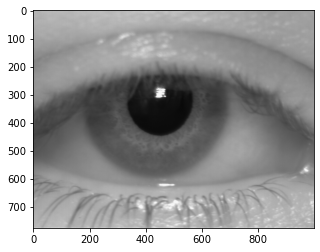

In [37]:
 plt.imshow(image, cmap=plt.cm.gray)

## Preprocessing of Image

In [38]:
import numpy as np

In [39]:
# Crops high value and blurr(MedianBlur) 
# to enhance the process of finding the iris.
img = image[:, :, 0].copy()
img[img > 225] = 30
cv2.medianBlur(img, 21)

array([[199, 199, 199, ..., 182, 182, 182],
       [182, 182, 182, ..., 163, 163, 163],
       [181, 181, 181, ..., 162, 162, 162],
       ...,
       [184, 184, 185, ..., 175, 175, 175],
       [185, 185, 185, ..., 176, 176, 175],
       [188, 188, 188, ..., 202, 202, 202]], dtype=uint8)

### Finding Pupil using Hough Transform

In [40]:
# HoughCircles give all the circles present in our image
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=200)
circles = np.uint16(np.around(circles))

In [41]:
# X,Y Co-ordinated of center of the iris
x = circles[0, 0][0]
y = circles[0, 0][1]

# Radius of iris
r = circles[0, 0][2]

print ("Cordinates of centre of the pupil are:", x, y)
print ("Radius of the pupil is:", r)

Cordinates of centre of the pupil are: 452 332
Radius of the pupil is: 116


### Finding the iris in the image usind integro-differential operator

In [42]:
def find_iris_id(img, x, y, r):
    x, y, r, l = find_segment(img, x, y, minr=max(int(1.25 * r), 100),
                              sigma=5, center_margin=30, jump=5)
    x, y, r, l = find_segment(img, x, y, minr=r - 10, maxr=r + 10,
                              sigma=2, center_margin=5, jump=1)
    return x, y, r

### Finding the segment (pupil or iris) in the image

In [43]:
# Return us the Iris part in the image
# Using the difference in radius
# Appliying Gaussian filter to blur to reduce noise
def find_segment(img, x0, y0, minr=0, maxr=500, step=1, sigma=5., center_margin=30, segment_type='iris', jump=1):
    max_o = 0
    max_l = []

    if img.ndim > 2:
        img = img[:, :, 0]
    margin_img = np.pad(img, maxr, 'edge')
    x0 += maxr
    y0 += maxr
    for x in range(x0 - center_margin, x0 + center_margin + 1, jump):
        for y in range(y0 - center_margin, y0 + center_margin + 1, jump):
            if segment_type == 'pupil':
                l = np.array([integrate(margin_img, y, x, r) for r in range(minr, maxr, step)])
            else:
                l = np.array([integrate(margin_img, y, x, r, 1 / 8, 3 / 8, n=8) +
                              integrate(margin_img, y, x, r, 5 / 8, 7 / 8, n=8)
                              for r in range(minr + abs(x0 - x) + abs(y0 - y), maxr, step)])
            l = (l[2:] - l[:-2]) / 2
            l = gaussian_filter(l, sigma)
            l = np.abs(l)
            max_c = np.max(l)
            if max_c > max_o:
                max_o = max_c
                max_l = l
                max_x, max_y = x, y
                r = np.argmax(l) * step + minr + abs(x0 - x) + abs(y0 - y)

    return max_x - maxr, max_y - maxr, r, max_l

### Finding the Line Integral in the image

In [44]:
import math
from scipy.ndimage.filters import gaussian_filter

In [45]:
def integrate(img, x0, y0, r, arc_start=0, arc_end=1, n=10):
    theta = 2 * math.pi / n
    integral = 0
    for step in np.arange(arc_start * n, arc_end * n, arc_end - arc_start):
        x = int(x0 + r * math.cos(step * theta))
        y = int(y0 + r * math.sin(step * theta))
        integral += img[x, y]
    return integral / n

In [46]:
x_iris, y_iris, r_iris = find_iris_id(img, x, y, r)
print ("Coordinates of iris are: (", x_iris, y_iris, ")")
print ("Radius of iris is:", r_iris)

Coordinates of iris are: ( 440 347 )
Radius of iris is: 250


## Showing image with iris and pupil marked with circles

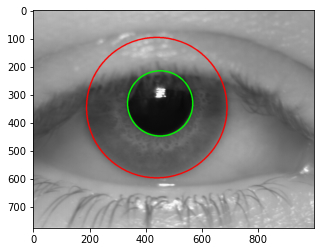

In [47]:
image_final = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.circle(image_final, (x,y), r, color=(0, 255, 0), thickness=3 )
cv2.circle(image_final, (x_iris, y_iris), r_iris, color=(255, 0, 0), thickness=3)
plt.imshow(image_final)

## Extracting Iris and transforming in straight representation

In [48]:
# Polar to cartesian cordinates transforming function
def polar2cart(r, x0, y0, theta):
    x = int(x0 + r * math.cos(theta))
    y = int(y0 + r * math.sin(theta))
    return x, y

In [49]:
#Extracting Iris and transforming in cartesian cordinates
if image.ndim > 2:
    image = image[:, :, 0].copy()
iris = np.zeros((150, 300))
theta = np.linspace(0, 2 * np.pi, 300)
for i in range(300):
    begin = polar2cart(r, x, y, theta[i])
    end = polar2cart(r_iris, x_iris, y_iris, theta[i])
    xspace = np.linspace(begin[0], end[0], 150)
    yspace = np.linspace(begin[1], end[1], 150)
    iris[:, i] = [255 - img[int(y), int(x)]
                  if 0 <= int(x) < image.shape[1] and 0 <= int(y) < image.shape[0]
                  else 0
                  for x,y in zip(xspace, yspace)]

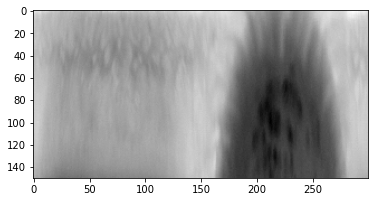

In [50]:
plt.imshow(iris, cmap=plt.cm.gray)

## Extracting Features

In [51]:
from skimage.util import view_as_blocks

In [52]:
# Uses gabor wavelet to extract iris features
def gabor_convolve(img, w, alpha, beta):
    rho = np.array([np.linspace(0, 1, img.shape[0]) for i in range(img.shape[1])]).T
    x = np.linspace(0, 1, img.shape[0])
    y = np.linspace(-np.pi, np.pi, img.shape[1])
    xx, yy = np.meshgrid(x, y)
    qwerty = np.exp(-w * 1j * (0 - yy)) * np.exp(-(xx - 0.5) ** 2 / alpha ** 2) * \
                                                    np.exp(-(yy - 0) ** 2 / beta ** 2)
    return rho * img * np.real(qwerty.T), \
           rho * img * np.imag(qwerty.T)

In [53]:
mask = view_as_blocks(np.logical_and(100 < iris, iris < 230), (15, 15))
norm_iris = (iris - iris.mean()) / img.std()
patches = view_as_blocks(norm_iris, (15, 15))
code = np.zeros((patches.shape[0] * 3, patches.shape[1] * 2))
code_mask = np.zeros((patches.shape[0] * 3, patches.shape[1] * 2))
for i, row in enumerate(patches):
    for j, p in enumerate(row):
        for k, w in enumerate([8, 16, 32]):
            wavelet = gabor_convolve(p, w, 0.4, 1 / 0.4)
            code[3 * i + k, 2 * j] = np.sum(wavelet[0])
            code[3 * i + k, 2 * j + 1] = np.sum(wavelet[1])
            code_mask[3 * i + k, 2 * j] = code_mask[3 * i + k, 2 * j + 1] = \
                    1 if mask[i, j].sum() > 15 * 15 * 3 / 4 else 0
code[code >= 0] = 1
code[code < 0] = 0

### Plotting extracted features

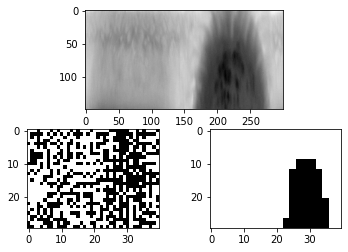

In [54]:
plt.subplot(211)
plt.imshow(iris, cmap=plt.cm.gray)
plt.subplot(223)
plt.imshow(code, cmap=plt.cm.gray, interpolation='none')
plt.subplot(224)
plt.imshow(code_mask, cmap=plt.cm.gray, interpolation='none')
plt.show()

## Saving Extracted features

In [46]:
np.save('Codes\\code{}'.format(i), np.array(code))
np.save('Codes\\mask{}'.format(i), np.array(code_mask))